In [14]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import corner
from copy import deepcopy
from matplotlib import gridspec
import matplotlib.lines as mlines
import glob

from scipy.stats import dirichlet
sys.path.append('../')

import populations.bbh_models as read_models
from populations import gw_obs


In [2]:
chi_b = [0.,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]

flowfile='/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/Flows_050924_Neventschib2/output_250events_logalphaCE.hdf5'
flow_result = h5py.File(f'{flowfile}', 'r')
hyper_posts = np.array(flow_result['model_selection']['samples']['block0_values'])
hyperpost_samp = hyper_posts[3973,:]

In [9]:
hyper_posts[3974,:]

array([0.18905108, 0.75087418, 0.72214188, 0.08808425, 0.11826167,
       0.05652415, 0.01498805])

In [6]:

file_path='/data/wiay/2297403c/models_reduced.hdf5'
params = ['mchirp','q', 'chieff', 'z']
channels =['CE', 'CHE', 'GC', 'NSC', 'SMT']

model_names, flow = read_models.get_models(file_path, channels, params, use_flows=True, device='cpu',\
     no_bins=[5,4,4,5,4], sensitivity='midhighlatelow', use_unityweights=False)

for channel in channels:
     flow[channel].load_model('/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/Flows_040924_trainlogalpha/flow_models/', \
          channel)   

100%|██████████| 5/5 [01:15<00:00, 15.19s/it]


In [24]:
hyperpost_samp = hyper_posts[3974,:]
no_total_samps = 1000001
total_samps = np.zeros((no_total_samps,len(params)))

samps_filled = np.zeros(6, dtype=int)

for cidx, channel in enumerate(channels):
    print(f'sampling {channel}...')
    no_channel_samps = int(np.round(no_total_samps*hyperpost_samp[2+cidx], decimals=0))
    if channel == 'CE':
        channel_samps = flow[channel].flow.sample(np.array([hyperpost_samp[:2]]), no_channel_samps)
    else:
        channel_samps = flow[channel].flow.sample(np.array([hyperpost_samp[:1]]), no_channel_samps)

    channel_samps[:,0] = flow[channel].expistic(channel_samps[:,0], flow[channel].mappings[0], flow[channel].mappings[1])
    channel_samps[:,1] = flow[channel].expistic(channel_samps[:,1], flow[channel].mappings[2])
    channel_samps[:,2] = np.tanh(channel_samps[:,2])
    channel_samps[:,3] = flow[channel].expistic(channel_samps[:,3], flow[channel].mappings[4], flow[channel].mappings[5])
    
    total_samps[samps_filled[cidx-1]:samps_filled[cidx-1]+no_channel_samps,:] = channel_samps
    samps_filled[cidx]=samps_filled[cidx-1]+no_channel_samps


sampling CE...
sampling CHE...
sampling GC...
sampling NSC...
sampling SMT...


In [120]:
corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="teal",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"

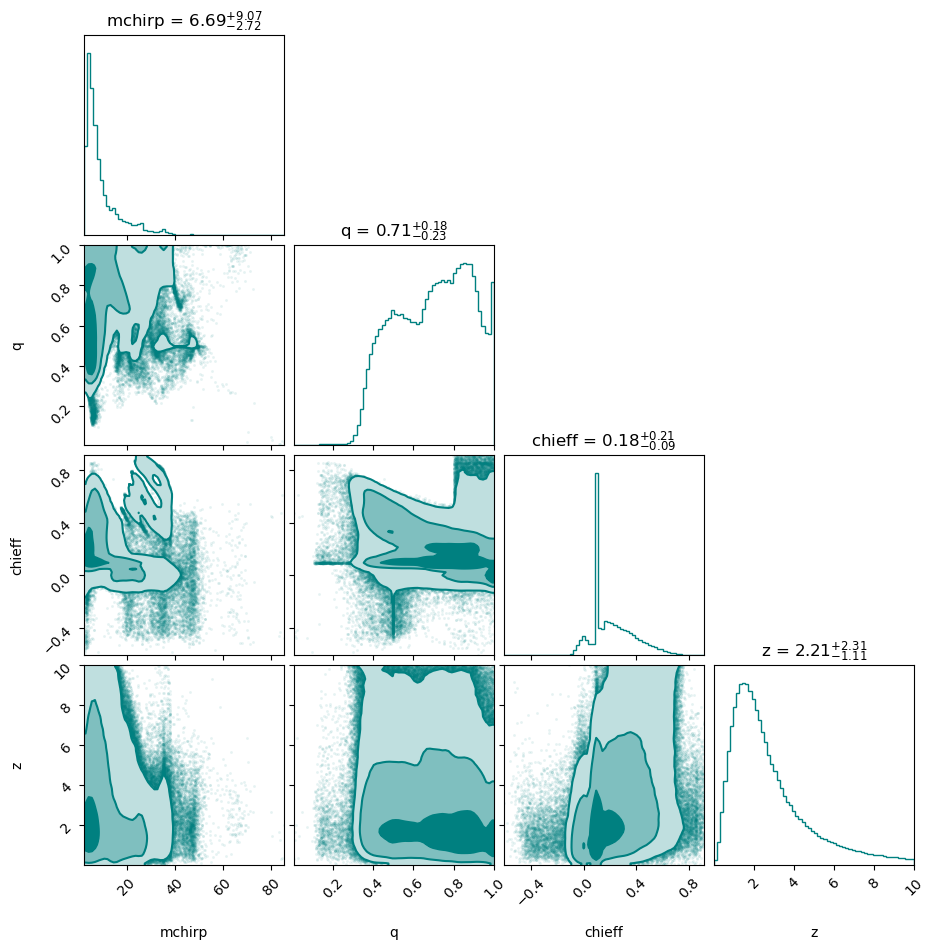

In [121]:
fig = corner.corner(total_samps[:-1], **corner_kwargs)


/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/corner/core.py:222: RuntimeWarning: invalid value encountered in log10
  np.log10(min(range[i])), np.log10(max(range[i])), n_bins_1d + 1
/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)
/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/corner/core.py:667: RuntimeWarning: invalid value encountered in log10
  np.log10(min(range[1])),


ValueError: It looks like at least one of your sample columns have no dynamic range. You could try using the 'range' argument.

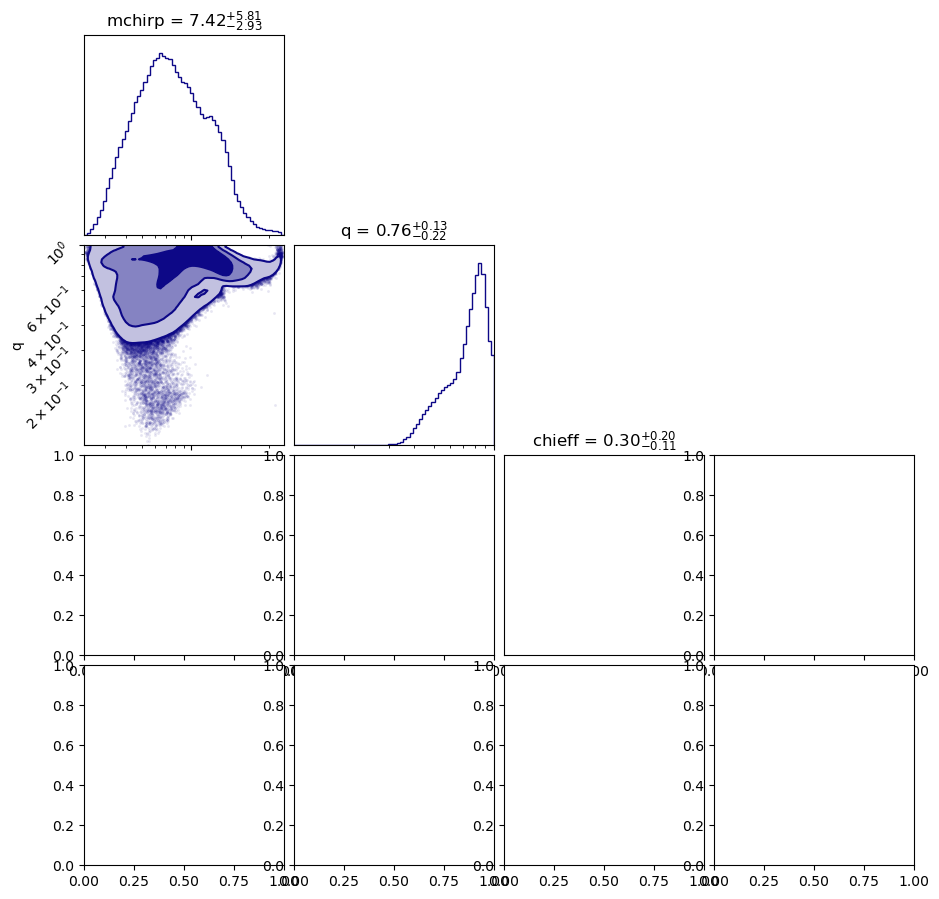

In [11]:
cmap = plt.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 6))
corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color=colors[0],
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)


fig=corner.corner(total_samps[samps_filled[-1]:samps_filled[0]], **corner_kwargs)

for cidx, channel in enumerate(channels[1:]):
    corner_kwargs["color"] = colors[cidx+1]
    corner.corner(total_samps[samps_filled[cidx]:samps_filled[cidx+1]], fig=fig, **corner_kwargs)
plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=channels[i])
            for i in range(5)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, 5), loc="upper right"
    )

In [15]:
#obs data
params = ['mchirp','q', 'chieff', 'z']
gw_path ='/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/simulated_events_processed/2_chi02'
Nsamps=1000

observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            Nsamps, 'posteriors', 'p_theta_jcb')

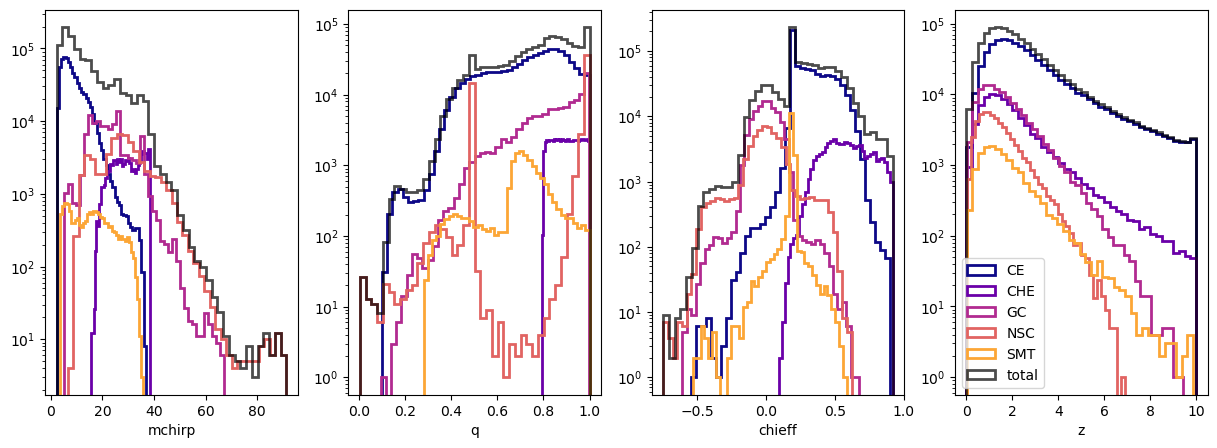

In [19]:
plt.rcParams["figure.figsize"] = (15,5)
fig,ax=plt.subplots(1,4)

for cidx, channel in enumerate(channels):
    for pidx,param in enumerate(params):
        ax[pidx].hist(total_samps[samps_filled[cidx-1]:samps_filled[cidx],pidx], color=colors[cidx], histtype='step', bins=40, lw=2,\
             label=channel)
        ax[pidx].set_yscale('log')
        ax[pidx].set_xlabel(param)

for pidx,param in enumerate(params):
    ax[pidx].hist(total_samps[:,pidx], color='black', histtype='step', bins=40, lw=2, ls='-', label='total', alpha=0.7)
plt.legend()

In [23]:
true_hyperpost_samp = np.array([0.2,1.,0.2,0.2,0.2,0.2,0.2])
no_total_samps = 1000001
true_total_samps = np.zeros((no_total_samps,len(params)))

samps_filled = np.zeros(6, dtype=int)

for cidx, channel in enumerate(channels):
    print(f'sampling {channel}...')
    no_channel_samps = int(np.round(no_total_samps*true_hyperpost_samp[2+cidx], decimals=0))
    if channel == 'CE':
        true_channel_samps = flow[channel].flow.sample(np.array([true_hyperpost_samp[:2]]), no_channel_samps)
    else:
        true_channel_samps = flow[channel].flow.sample(np.array([true_hyperpost_samp[:1]]), no_channel_samps)

    true_channel_samps[:,0] = flow[channel].expistic(true_channel_samps[:,0], flow[channel].mappings[0], flow[channel].mappings[1])
    true_channel_samps[:,1] = flow[channel].expistic(true_channel_samps[:,1], flow[channel].mappings[2])
    true_channel_samps[:,2] = np.tanh(true_channel_samps[:,2])
    true_channel_samps[:,3] = flow[channel].expistic(true_channel_samps[:,3], flow[channel].mappings[4], flow[channel].mappings[5])
    
    true_total_samps[samps_filled[cidx-1]:samps_filled[cidx-1]+no_channel_samps,:] = true_channel_samps
    samps_filled[cidx]=samps_filled[cidx-1]+no_channel_samps

sampling CE...
sampling CHE...
sampling GC...
sampling NSC...
sampling SMT...


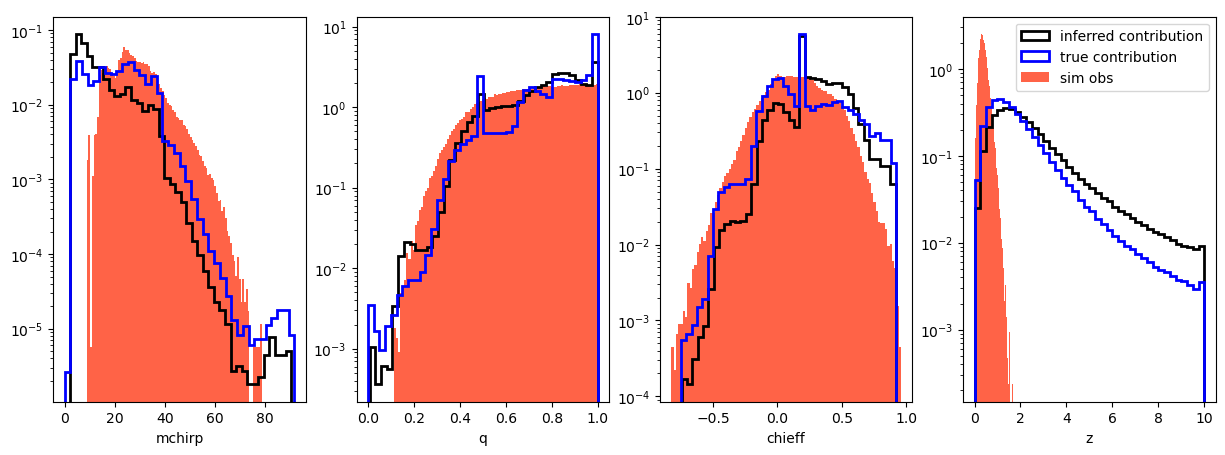

In [27]:
plt.rcParams["figure.figsize"] = (15,5)
fig,ax=plt.subplots(1,4)

for pidx,param in enumerate(params):
    ax[pidx].hist(total_samps[:,pidx], color='black', histtype='step', bins=40, lw=2, ls='-', label='inferred contribution', density=True)
    ax[pidx].hist(true_total_samps[:,pidx], color='blue', histtype='step', bins=40, lw=2, ls='-', label='true contribution', density=True)

    ax[pidx].hist(np.reshape(obsdata[:,:,pidx], obsdata[:,:,pidx].shape[0]*obsdata[:,:,pidx].shape[1]), bins=100,\
         color='tomato', density=True, label='sim obs')
    ax[pidx].set_yscale('log')
    ax[pidx].set_xlabel(param)

plt.legend()

In [19]:
import deepdish as dd

def CDF(distr, theta):
    """
    Calculates a CDF of a PDF (distr) supplied at points theta
    """
    CDF = []
    for i in range(len(theta)):
        CDF.append(np.trapz(distr[:i+1], theta[:i+1]))
    return CDF, theta

def sample_1D(distr, theta, N):
    """
    returns samples from distribution calculated by interpolation of a given distribution

    Parameters
    ----------
    distr: numpy array
        values of a probability distribution of one of the binary parameters
    theta: numpy
        values of binary parameter at locations of probability distribution
    N: int
        number of samples to return from distr

    Returns
    -------
    samps: numpy array
        samples from distr
    """
    rand = np.random.random(N)
    CDF_theta, theta = CDF(distr/np.trapz(distr, theta), theta)
    samps = np.interp(rand, CDF_theta, theta)
    return samps


In [2]:
filename = '/data/wiay/2297403c/GW_ChirpSim/GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
with open(filename, 'r') as _data:
    _data = dd.io.load(filename)
    lines = _data["lines"]
    ppd = _data["ppd"]



In [27]:
m1s = np.linspace(2, 100, 1000)
qs = np.linspace(0.1, 1, 500)

N=1
mchirp_samps = np.zeros(10000)
q_samps = np.zeros(10000)

for lambda_i in range(10000):
    m1_samp = sample_1D(lines['mass_1'][lambda_i,:], m1s, N)
    q_samp = sample_1D(lines['mass_ratio'][lambda_i,:], qs, N)

    mchirp_samps[lambda_i] = m1_samp*(q_samp**3/(1+q_samp))
    q_samps[lambda_i] = q_samp



/tmp/ipykernel_1126836/3274263274.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mchirp_samps[lambda_i] = m1_samp*(q_samp**3/(1+q_samp))
/tmp/ipykernel_1126836/3274263274.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_samps[lambda_i] = q_samp


(array([4.380e+02, 7.800e+02, 1.386e+03, 2.138e+03, 1.720e+03, 9.930e+02,
        5.870e+02, 3.820e+02, 2.280e+02, 1.870e+02, 1.450e+02, 1.360e+02,
        1.130e+02, 1.090e+02, 1.050e+02, 9.900e+01, 9.600e+01, 9.700e+01,
        7.100e+01, 5.300e+01, 3.700e+01, 2.300e+01, 2.100e+01, 1.900e+01,
        5.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.85273243e-02, 9.01135296e-01, 1.78374327e+00, 2.66635124e+00,
        3.54895921e+00, 4.43156718e+00, 5.31417516e+00, 6.19678313e+00,
        7.07939110e+00, 7.96199907e+00, 8.84460704e+00, 9.72721501e+00,
        1.06098230e+01, 1.14924310e+01, 1.23750389e+01, 1.32576469e+01,
        1.41402549e+01, 1.50228628e+01, 1.59054708e+01, 1.67880788e+01,
        1.76706868e+01, 1.85532947e+01, 1.94359027e+01, 2.03185107e+01,
        2.12011186e+01, 2.20837266e+01, 2.29663346e+01, 2.38489426e+01

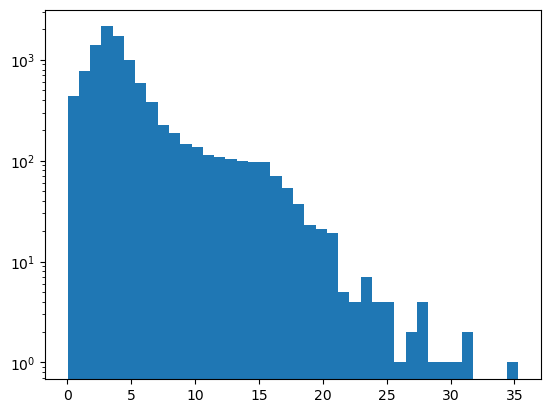

In [28]:
plt.hist(mchirp_samps, bins=40,log=True)

(array([   2.,    4.,    4.,    5.,   11.,    9.,   13.,   16.,   21.,
          15.,   23.,   27.,   45.,   36.,   45.,   53.,   54.,   69.,
          80.,   96.,   93.,  120.,  125.,  130.,  156.,  184.,  204.,
         248.,  288.,  308.,  347.,  426.,  459.,  545.,  625.,  755.,
         840.,  941., 1165., 1413.]),
 array([0.13118877, 0.15290881, 0.17462885, 0.19634889, 0.21806893,
        0.23978897, 0.26150901, 0.28322904, 0.30494908, 0.32666912,
        0.34838916, 0.3701092 , 0.39182924, 0.41354928, 0.43526931,
        0.45698935, 0.47870939, 0.50042943, 0.52214947, 0.54386951,
        0.56558955, 0.58730959, 0.60902962, 0.63074966, 0.6524697 ,
        0.67418974, 0.69590978, 0.71762982, 0.73934986, 0.76106989,
        0.78278993, 0.80450997, 0.82623001, 0.84795005, 0.86967009,
        0.89139013, 0.91311017, 0.9348302 , 0.95655024, 0.97827028,
        0.99999032]),
 <BarContainer object of 40 artists>)

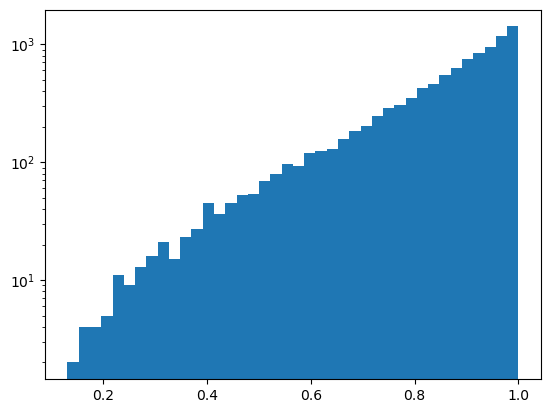

In [29]:
plt.hist(q_samps, bins=40,log=True)